In this notebook we used the fish tracks position information to calculate fish tilt (following Dunning et al., 2023)


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

import sys, errno  


In [2]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [11]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
ppath = 'G:/AFKABAN/Pcod_190123/'
p2path = 'G:/AFKABAN/Pcod2_240123/'
apath = 'G:/AFKABAN/Acod_200123/'
pbpath = 'G:/AFKABAN/Pandalus_260123/'
kpath = 'G:/AFKABAN/Krill_270123/'


In [12]:
def tsf_targets_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df, avg_flag):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        if avg_flag:
            df['Ping_microseconds_start'] = df.Ping_millisecond_start * 1000
            df['Ping_microseconds_start'] = [timedelta(microseconds = i) for i in df['Ping_microseconds_start']]
            df['Datetime'] = df['Ping_date_start_Ping_time_start'] + df['Ping_microseconds_start']
            df.drop(columns=['Ping_date_start_Ping_time_start',
                             'Ping_millisecond_start',
                             'Ping_microseconds_start'], 
                    inplace=True)
        
        else:
            df['Ping_microseconds'] = df.Ping_milliseconds * 1000
            df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
            df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
            df.drop(columns=['Ping_date_Ping_time',
                             'Ping_milliseconds',
                             'Ping_microseconds'],
                    inplace=True)
        
        return df
    
    if "trackavg.csv" in file_path:
        parse_cols = ['Ping_date_start', 'Ping_time_start']
        ind_col = None
        avg_flag = True
        transpose = True
    if "target" in file_path:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = None
        avg_flag = False
        transpose = False
    else:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = 'Target_index'
        avg_flag = False
        transpose = True
        
    if transpose:
        transposed_path = file_path[:-4] + '_transposed.csv'
        if os.path.isfile(transposed_path) == True:
            df = pd.read_csv(transposed_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
        else:
            df = pd.read_csv(file_path, low_memory=False).T
            file_path = transposed_path
            df.to_csv(path_or_buf=file_path)
            print('A transposed TS(f) file was created at: \n' + str(file_path))    
            df = pd.read_csv(file_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
    else:
        df = pd.read_csv(file_path,
                 index_col=ind_col,
                 skiprows=0,
                 skipfooter=2,
                 engine='python',
                 parse_dates=[parse_cols])
    
    df = get_datetime(df, avg_flag)
    
    return df

## Combine target and track data
For the tilt calculations, we need information on the track, the major and minor axis angles and range. These informations are found in different Echoview exports. 

Here I combine the:
- from the SED echogram -> Single targetss to CSV..,
- Analysis by region, Wideband frequency response...


In [13]:
def join_targettracks(path):
    """
    This function imports wideband frequency response of tracks and single target export .csv files exported from
    Echoview and combines them to match data on target spectra, track and in-beam target position.
    
    PARAMETERS:
        path: Path to wideband frequency response + single target .csv file from Echoview.
        
    RETURNS:
        targettracks_df: Pandas dataframe.
    """
    
    # Determine paths
    tracks_path = path+"SED_tsf_tracks.csv"
    target_path = path+'all_SED.target.csv'
    
    # Read tracks import (from Export by Regions -> Wideband frequecy response (both frequencies))
    tracks_df = tsf_targets_import(tracks_path)
    tracks_df = tracks_df.rename(columns={'Ping_index':'Ping_number','Range':'Target_range'})
    
    # Read target info (from Single target to csv. includes ALL SED)
    target_df = tsf_targets_import(target_path)

    # Select columns to keep
    target_df = target_df[['Ping_number', 'Target_range', 'Angle_minor_axis', 'Angle_major_axis']]
    # Match multi index
    tracks = tracks_df.set_index(['Ping_number','Target_range'])
    target = target_df.set_index(['Ping_number','Target_range'])
    # Join dataframes for target position and ts(f) for SED in tracks
    new_df = tracks.join(target)
    targettracks_df = new_df.reset_index()
    
    targettracks_df = targettracks_df.sort_values(['Region_name','Ping_number'])
    
    return targettracks_df

In [15]:
a_df = join_targettracks(apath)
p_df = join_targettracks(ppath)
p2_df = join_targettracks(p2path)
pb_df = join_targettracks(pbpath)



A transposed TS(f) file was created at: 
G:/AFKABAN/Pcod2_240123/SED_tsf_tracks_transposed.csv


## Calculate parameters for tilt calculations
Following equations and assumptions from Dunning et al. (2023):
- $x = ztan(\theta)$
- $y = ztan(\phi)$
- $z = \sqrt{(r^2 - (x^2 + y^2))}$ -> - $z = \sqrt{r^2 \over tan^2(\theta)+tan^2(\phi)+1}$,


where $\theta$ is alongship (minor axis) angle and $\phi$ is athwartship (major axis) angle. and r is the range


The tilt angle is calculated by the elevation ($\alpha$) between two points. We calculate it through the projection on the XY plane and the distance elevations.
 $\tan{z_2-z_1 \over \sqrt{(x_2-x_1)^2+(y_2-y_1)^2}}$

In [7]:
def calculate_tilt(df):
    
    # Calculate xyz coordinates from range and position in beam
    df['z'] = np.sqrt(df['Target_range']**2/((np.tan(df['Angle_minor_axis'])**2)+(np.tan(df['Angle_major_axis'])**2)+1))
    df['x'] = df['z']*np.tan(df['Angle_minor_axis'])
    df['y'] = df['z']*np.tan(df['Angle_major_axis'])

    alpha = np.zeros(len(df))*np.nan
    tilt = np.zeros(len(df))*np.nan
    
    # Select a track
    n_tracks = df['Region_name'].unique()
    for i_track in range(len(n_tracks)):
        track_inds = np.where(df['Region_name']==n_tracks[i_track])[0]
        
        # No smoothing by cubic spline, we found this added more variability in the values and increased the spread of the data.
        for i in track_inds[:-1]:
            # Calculate distance from i
            del_x = df['x'][i+1] - df['x'][i]
            del_y = df['y'][i+1] - df['y'][i]
            del_z = df['z'][i+1] - df['z'][i]

            # Projection of distance on XY plane
            del_xy = np.sqrt(del_x**2+del_y**2)
            # Angle of XY distance and elevation
            alpha[i] = np.rad2deg(np.arctan(del_z/del_xy))
        
        # tilt at i is average of alpha between [i-1,i] and [i,i+1]
        for i in track_inds[1:-1]:
            tilt[i] = np.mean([alpha[i-1:i+1]])

    # First and last detections in a track should be NaN
    df['tilt'] = tilt
    df['alpha'] = alpha
    
    return df

In [16]:
a_tilt_df = calculate_tilt(a_df)
p_tilt_df = calculate_tilt(p_df)
p2_tilt_df = calculate_tilt(p2_df)
pb_tilt_df = calculate_tilt(pb_df)

C:\Users\mbd\AppData\Local\Temp\ipykernel_82776\4154700337.py:26: RuntimeWarning: invalid value encountered in double_scalars
  alpha[i] = np.rad2deg(np.arctan(del_z/del_xy))
C:\Users\mbd\AppData\Local\Temp\ipykernel_82776\4154700337.py:26: RuntimeWarning: invalid value encountered in double_scalars
  alpha[i] = np.rad2deg(np.arctan(del_z/del_xy))
C:\Users\mbd\AppData\Local\Temp\ipykernel_82776\4154700337.py:26: RuntimeWarning: invalid value encountered in double_scalars
  alpha[i] = np.rad2deg(np.arctan(del_z/del_xy))
C:\Users\mbd\AppData\Local\Temp\ipykernel_82776\4154700337.py:26: RuntimeWarning: invalid value encountered in double_scalars
  alpha[i] = np.rad2deg(np.arctan(del_z/del_xy))


### Plot distribution of tilt for all SED in tracks

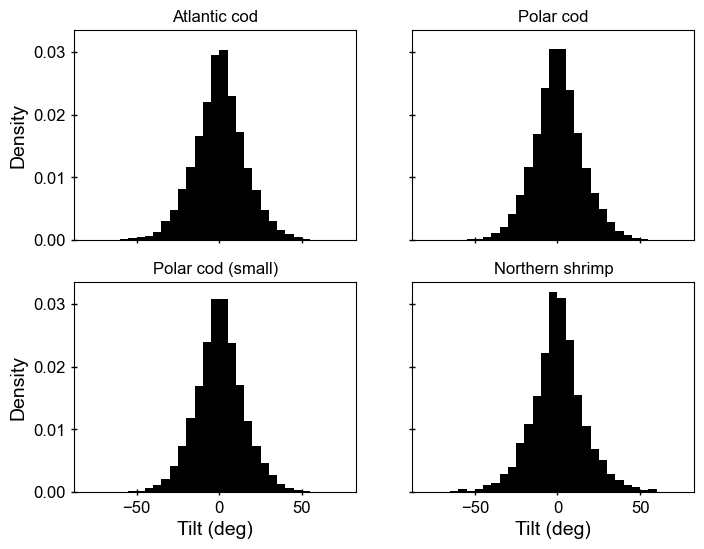

In [35]:
## set up bins
bin_array = np.arange(-80,80,5) 
fig, ax = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True)
axes = ax.flatten()

axes[0].hist(a_tilt_df['tilt'], bins = bin_array, density=True, color='k', label='Atlantic cod')
axes[1].hist(p_tilt_df['tilt'], bins = bin_array, density=True, color='k', label='Polar cod')
axes[2].hist(p2_tilt_df['tilt'], bins = bin_array, density=True, color='k',  label='Polar cod (small)')
axes[3].hist(pb_tilt_df['tilt'], bins = bin_array, density=True, color='k',  label='Pandalus')

axes[0].set_title('Atlantic cod')
axes[1].set_title('Polar cod')
axes[2].set_title('Polar cod (small)')
axes[3].set_title('Northern shrimp')

axes[0].set_ylabel('Density')
axes[2].set_ylabel('Density')
axes[2].set_xlabel('Tilt (deg)')
axes[3].set_xlabel('Tilt (deg)');

In [95]:
## Plot by tilt
df = a_tilt_df
df['tilt'] = df['tilt'].round()
df_tilt = df.groupby(['tilt']).median(numeric_only=True)
df
df_tilt[df_tilt<-99]=np.nan

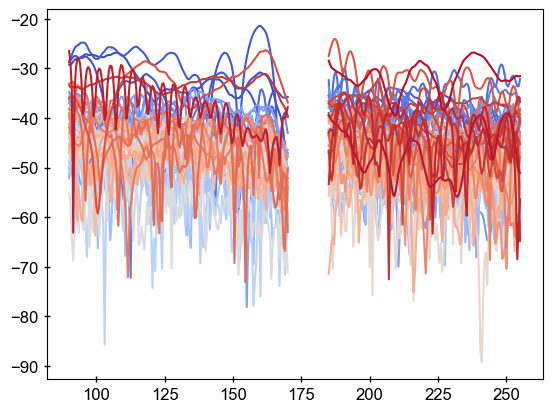

In [117]:
freqs = df.columns.unique()[4:-8].values.astype(np.float64)
c_palette = sns.color_palette('coolwarm',n_colors=len(df_tilt.index))

for i_tilt in range(len(df_tilt.index)):
    plt.plot(freqs,df_tilt.iloc[i_tilt,3:-6].T, color=c_palette[i_tilt]);

In [97]:
df_tilt

,Ping_number,Target_range,Depth,90.000,90.500,91.000,91.500,92.000,92.500,93.000,...,253.500,254.000,254.500,255.000,Angle_minor_axis,Angle_major_axis,z,x,y,alpha
tilt,,,,,,,,,,,,,,,,,,,,,
-60.0,10890.0,5.823651,5.812934,-29.263770,-29.289173,-29.004261,-28.618315,-28.298978,-28.123461,-28.065200,...,NaN,NaN,NaN,NaN,-1.637015,2.758150,4.582605,-0.495682,-2.087154,-72.268010
-57.0,12415.0,5.354143,5.338163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-39.274678,-39.649189,-39.691802,-39.436510,-1.372000,-1.036500,2.206181,1.410219,-4.387953,-63.139141
-56.0,10654.0,4.689250,4.685111,-28.528854,-28.337051,-28.013085,-27.669655,-27.496949,-27.508678,-27.719235,...,NaN,NaN,NaN,NaN,0.786770,-2.275400,2.547237,2.554236,2.996084,-76.395632
-55.0,12012.0,4.916713,4.910314,-28.753386,-28.026593,-27.282478,-26.532985,-25.960802,-25.557919,-25.395478,...,NaN,NaN,NaN,NaN,0.031809,-2.923500,4.797931,0.152669,1.063306,-72.263440
-54.0,11527.5,5.144177,5.137032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.019300,0.494635,4.454662,0.805828,2.159805,-53.151024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61.0,561.0,4.823395,4.806610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-42.791715,-44.054722,-48.557666,-64.813608,-3.446100,-3.322300,4.533153,-1.424688,-0.828209,60.347362
63.0,5157.0,6.293160,6.286325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-55.954771,-68.496212,-61.127306,-56.346233,-2.613900,0.547670,4.810160,2.803466,2.933735,51.035485
64.0,9764.0,6.246500,6.215334,-26.495150,-29.016230,-34.395161,-63.137431,-34.623819,-29.823651,-28.062654,...,NaN,NaN,NaN,NaN,3.690500,-4.390100,1.942397,1.187976,-5.816750,49.711633
